# Introduction

Climate and pesticides are always important factors in crop productivity. In this study, I introduce a machine learning model that can forecast crop production value by taking into account the average annual rainfall, pesticide use, and temperature of that site. This study makes use of a publicly available dataset from the FAO (Food and Agriculture Organization) and the World Data Bank.
For our study, we considered crop production data from 101 countries from 1990 to 2013 and the crops are,
        Cassava
        Maize
        Plantains and others
        Potatoes
        Rice, paddy
        Sorghum
        Soybeans
        Sweet potatoes
        Wheat
        Yams

In [30]:
import numpy as np                                   #linear algebra
import pandas as pd                                  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt                      #creating graphical plots 
import seaborn as sns                                # used for data visualizatin
from sklearn.preprocessing import LabelEncoder       # encoding labels to numeric data
from sklearn.preprocessing import StandardScaler     #scaling operations 
from sklearn.model_selection import train_test_split #splitting data into training and test data
from sklearn.linear_model import LogisticRegression  #include logistic regression models
from sklearn.tree import DecisionTreeRegressor       # generate decision tre regressor model
from sklearn.metrics import r2_score,confusion_matrix# checking accuracy of the model
from sklearn.naive_bayes import GaussianNB           # include Gaussian Naive Bayes
from sklearn.ensemble import GradientBoostingRegressor# include Gradient Boosting Regression model
from sklearn import neighbors


# Data Introduction and Preprocessing

In [31]:
#read yiled data from system
yield_data = pd.read_csv("../input/crop-yield-prediction-dataset/yield_df.csv")
#remove unwanted colums from dataset
yield_data = yield_data.drop(['Unnamed: 0','Year'],axis = 1)
#display the first five records from file
yield_data.head()

,Area,Item,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,36613,1485.0,121.0,16.37
1,Albania,Potatoes,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",23333,1485.0,121.0,16.37
3,Albania,Sorghum,12500,1485.0,121.0,16.37
4,Albania,Soybeans,7000,1485.0,121.0,16.37


The entire data set is loaded into dataframe yiled data.The yiled_data collection includes data on the region, crop, year, and yiled production in hg/ha units along with information on the region's average temperature, rainfall, and pesticide use. Since the year has no bearing on yield prediction, remove the year data column from the data collection.


In [32]:
#retrieve the number of records and other details of that dataset 
yield_data.describe()

,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.00000,28242.000000,28242.000000
mean,77053.332094,1149.05598,37076.909344,20.542627
std,84956.612897,709.81215,59958.784665,6.312051
min,50.000000,51.00000,0.040000,1.300000
25%,19919.250000,593.00000,1702.000000,16.702500
50%,38295.000000,1083.00000,17529.440000,21.510000
75%,104676.750000,1668.00000,48687.880000,26.000000
max,501412.000000,3240.00000,367778.000000,30.650000


We may occasionally have null data since we have so many data points, which could cause our model to be inaccurate. We must count the number of null data in the data collection and discard them before moving on to the next step.

In [33]:
#finding null values from the dataset
yield_data.isnull().sum()

Area                             0
Item                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64

There are no null values, so we are ready to continue processing the data.

In [34]:
#unique values per item
yield_data['Area'].nunique()


101

In [8]:
yield_data['Item'].nunique()


10

As previously mentioned, 101 countries and 10 crop types are taken into consideration in our study.

Text(0.5, 0.01, 'Figure 1')

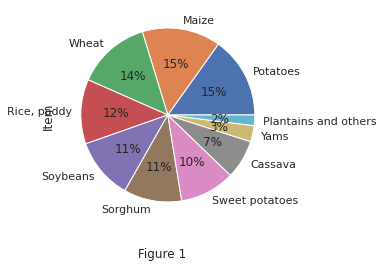

In [35]:
#print 10 unique crop values along with the yield production 
yield_data['Item'].value_counts().plot(kind='pie',autopct='%1.0f%%')
plt.figtext(0.5, 0.01, 'Figure 1', horizontalalignment='center', fontsize=12)

In [36]:
#display  countries and item with high production count
yield_data.groupby(['Area', 'Item'])['hg/ha_yield'].sum().nlargest(10)

Area            Item          
India           Cassava           142810624
                Potatoes           92122514
Brazil          Potatoes           49602168
United Kingdom  Potatoes           46705145
Australia       Potatoes           45670386
India           Sweet potatoes     44439538
Japan           Potatoes           42918726
Mexico          Potatoes           42053880
                Sweet potatoes     35808592
Australia       Sweet potatoes     35550294
Name: hg/ha_yield, dtype: int64

Text(0.5, 0.0, 'Figure 2')

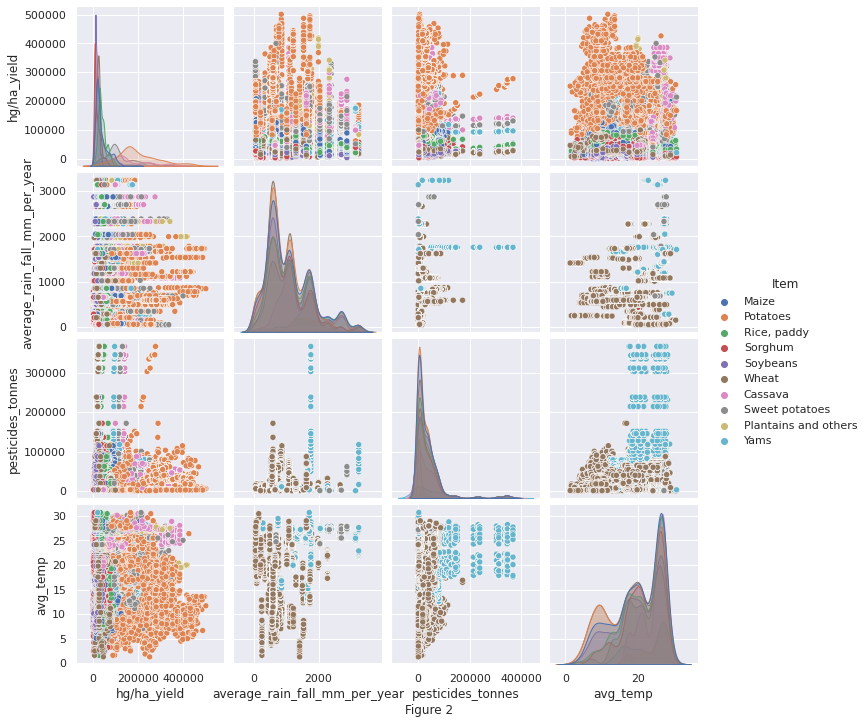

In [38]:
#plot pairwise realtionship between each item with other features of the data set
sns.pairplot(yield_data, hue="Item")
plt.figtext(0.5, 0.00, 'Figure 2',wrap=True, horizontalalignment='center', fontsize=12)

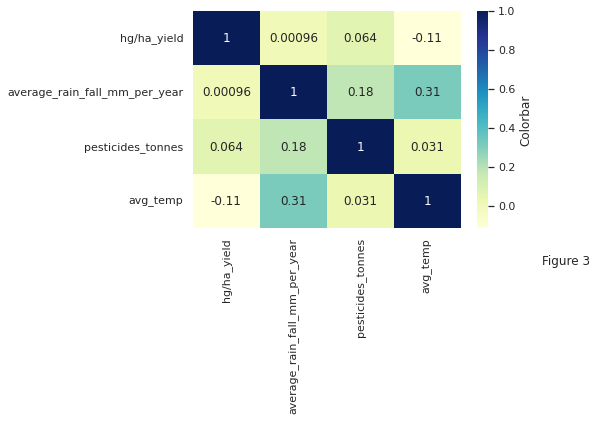

In [39]:
#Lets esaily display these correlation as a heat map
sns.set(font_scale=1)
sns.heatmap(yield_data.corr(),annot=True,cbar_kws={'label': 'Colorbar'},cmap="YlGnBu")
plt.figtext(0.99, 0.00, 'Figure 3',wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

The corelation value will lie between +1 and -1. The positive value imply that both variables are begun increasing/decreasing concurrently. If one varibale is increasing when other value drop then the corerelation is negative. From the aforementioned corelation graph we can cleary state that the variables are not co-related.

Text(0.5, 0.05, 'Figure 4')

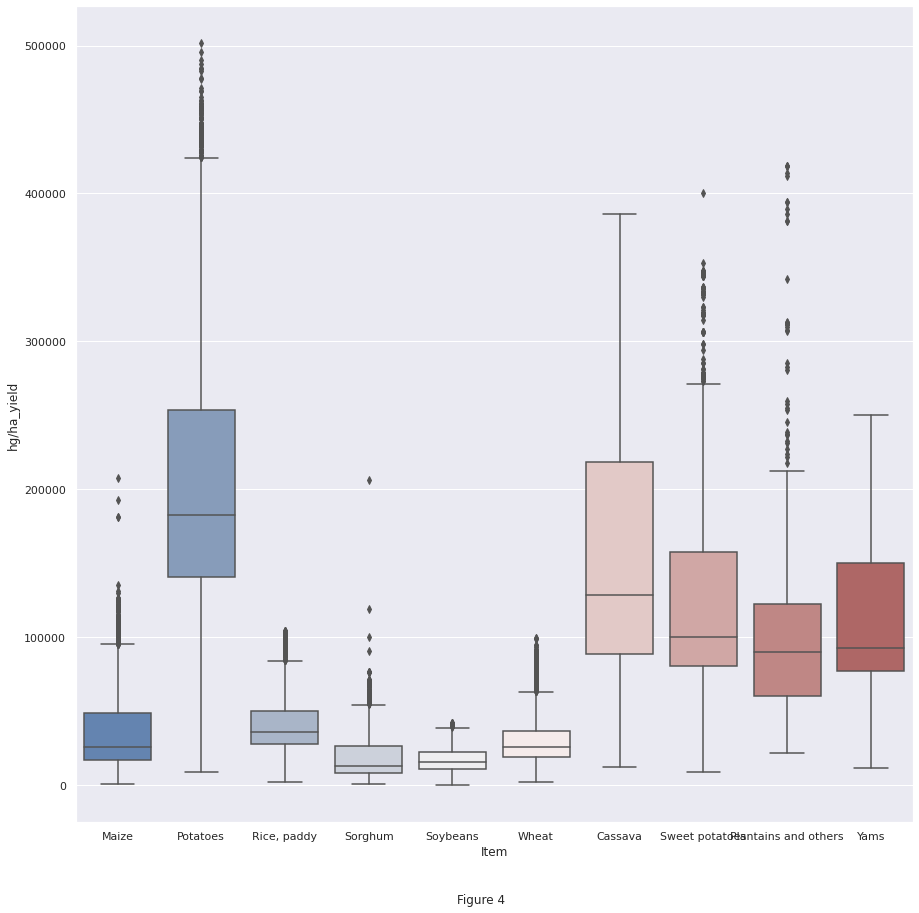

In [41]:
#display the crop yiled production data
plt.subplots(1,figsize=(15,15) )
sns.boxplot(x="Item",y="hg/ha_yield",palette="vlag",data=yield_data)
plt.figtext(0.5, 0.05, 'Figure 4',wrap=True, horizontalalignment='center', fontsize=12)

The total production is shown in figure 4 at the item level. When compared to all other crops, potatoes produce at a high rate. When combining the production range of 101 countries, soybeans are the crop that is farmed the least.

In [42]:
#information about the data types of the variables 
yield_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           28242 non-null  object 
 1   Item                           28242 non-null  object 
 2   hg/ha_yield                    28242 non-null  int64  
 3   average_rain_fall_mm_per_year  28242 non-null  float64
 4   pesticides_tonnes              28242 non-null  float64
 5   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.3+ MB


In the dataset, Area and Item are categorical values, and for  machine learning algorithms it is difficult to make predictions with categorical values.As a result, those must be converted into numerical numbers.

In [44]:
#create numerical variables for Area and Item. Also remove those caterocal values from data frame
yield_dummies = pd.get_dummies(yield_data, columns = ['Area','Item'],drop_first = True)
yield_dummies


,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Area_Algeria,Area_Angola,Area_Argentina,Area_Armenia,Area_Australia,Area_Austria,...,Area_Zimbabwe,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,Item_Soybeans,Item_Sweet potatoes,Item_Wheat,Item_Yams
0,36613,1485.0,121.00,16.37,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,66667,1485.0,121.00,16.37,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,23333,1485.0,121.00,16.37,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,12500,1485.0,121.00,16.37,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,7000,1485.0,121.00,16.37,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28237,22581,657.0,2550.07,19.76,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
28238,3066,657.0,2550.07,19.76,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
28239,13142,657.0,2550.07,19.76,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
28240,22222,657.0,2550.07,19.76,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [45]:
#divide the data set into features and labels 
labels = yield_dummies['hg/ha_yield']
features = yield_dummies.drop('hg/ha_yield',axis = 1)

The dataset includes features with varying dimensions and sizes. Data feature sizes have a negative impact on dataset modeling. As a result, we must scale the values to a common scale with a mean of 0 and a standard deviation of 1. The mean is eliminated, and the data is scaled to the unit variance using Python's StandardScaler function.

In [47]:
#create scalar object and fit the object and transform the data
features_scaled = StandardScaler().fit_transform(features)

features_scaled

array([[ 0.47329419, -0.61636612, -0.66106889, ..., -0.33763138,
        -0.39770719, -0.17583529],
       [ 0.47329419, -0.61636612, -0.66106889, ..., -0.33763138,
        -0.39770719, -0.17583529],
       [ 0.47329419, -0.61636612, -0.66106889, ..., -0.33763138,
        -0.39770719, -0.17583529],
       ...,
       [-0.69323228, -0.57585308, -0.12399147, ..., -0.33763138,
        -0.39770719, -0.17583529],
       [-0.69323228, -0.57585308, -0.12399147, ...,  2.96180998,
        -0.39770719, -0.17583529],
       [-0.69323228, -0.57585308, -0.12399147, ..., -0.33763138,
         2.51441269, -0.17583529]])

# Model Generation

Our data has been cleansed and is ready to be input into the model. Three regression algorithms are utilized in this study to generate machine learning models from the dataset. Using the accuracy measurements, we may later compare the efficacy of those models. Decision Tree Regression, Gaussian Naive Bayes, and Gradient Boosting Regression are the three algorithms implemented in this study. 

In [63]:
#initialize variables to store model names and R2 scores of each model.
models = []
scores = []

In [76]:
#70%data used for traing and 30% data for tesing purpose
train_data,test_data, train_labels, test_labels = train_test_split(features_scaled, labels, test_size=0.3, random_state=42)
test_data

array([[-0.72281809,  0.06074431, -0.52798776, ..., -0.33763138,
        -0.39770719, -0.17583529],
       [ 0.51274195, -0.61584893, -0.13191296, ..., -0.33763138,
         2.51441269, -0.17583529],
       [-0.72281809,  0.03279128, -0.6388887 , ..., -0.33763138,
        -0.39770719, -0.17583529],
       ...,
       [ 1.19321572, -0.41817097, -0.08913688, ..., -0.33763138,
         2.51441269, -0.17583529],
       [ 1.2566139 , -0.60618462,  0.65389944, ..., -0.33763138,
        -0.39770719, -0.17583529],
       [ 0.86213635,  4.59590652, -0.42183971, ..., -0.33763138,
        -0.39770719, -0.17583529]])

**Decision Tree Regression model**

In [67]:
#Model generation
yiled_dt = DecisionTreeRegressor()
yiled_dt.fit(train_data , train_labels)

#model prediction
y_pred_dt = yiled_dt.predict(test_data)

#model evaluation
score_dt =r2_score(test_labels,y_pred_dt)
models.append('DecisionTreeRegressor')
scores.append(score_dt)

score_dt

0.9606142834608234

Our model's accuracy is measured using the R-squared error value. The goodness of fit or best-fit line is measured using the R-squared value. The higher the R-squared score, the better the model. R-squared value is shown here. 96 means that the forecast made by our model is 96% accurate.

In [68]:
#convert the data into a data frame for displaying results
test_labels["hg/ha_yield"] = pd.DataFrame(test_labels)["hg/ha_yield"].tolist()

Text(0.5, 0.05, 'Figure 5')

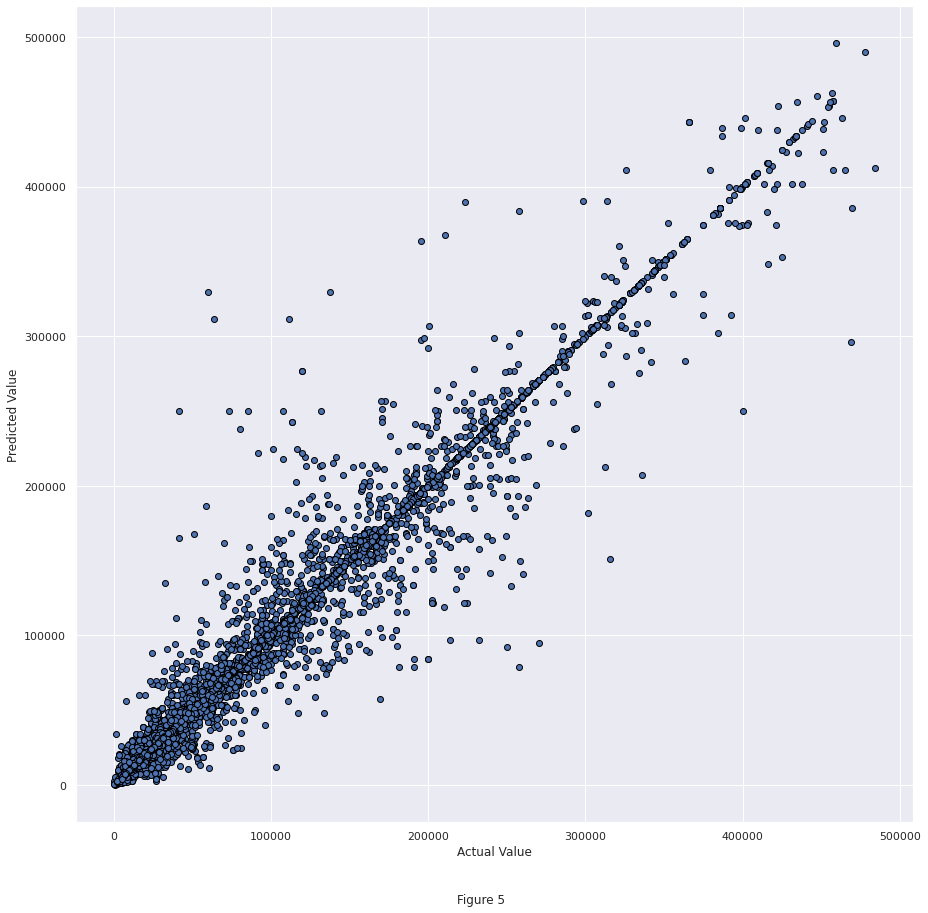

In [69]:
plt.figure(figsize=(15,15))
plt.scatter(test_labels["hg/ha_yield"], y_pred_dt,edgecolors=(0, 0, 0))
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.figtext(0.5, 0.05, 'Figure 5',wrap=True, horizontalalignment='center', fontsize=12)

Figure 5 depicts a scatter plot of actual vs expected values. The fugure will provide us with a clear conclusion. All of your points should ideally be near to a regression diagonal line. The majority of our data points are clustered on the diagonal line, indicating that our model is performing effectively on the data.

**Gaussian Naive Bayes model**

In [71]:
#model generation and prediction
yield_gnb = GaussianNB()
y_pred_gnb = yield_gnb.fit(train_data, train_labels).predict(test_data)

#model evaluation
score_gnb = r2_score(test_labels,y_pred_gnb)
models.append('Gaussian Naive Bayes ')
scores.append(score_gnb)
score_gnb

0.7912356904433824

In [72]:
#convert the data into a data frame for displaying results
test_labels["hg/ha_yield"] = pd.DataFrame(test_labels)["hg/ha_yield"].tolist()

Text(0.5, 0.05, 'Figure 6')

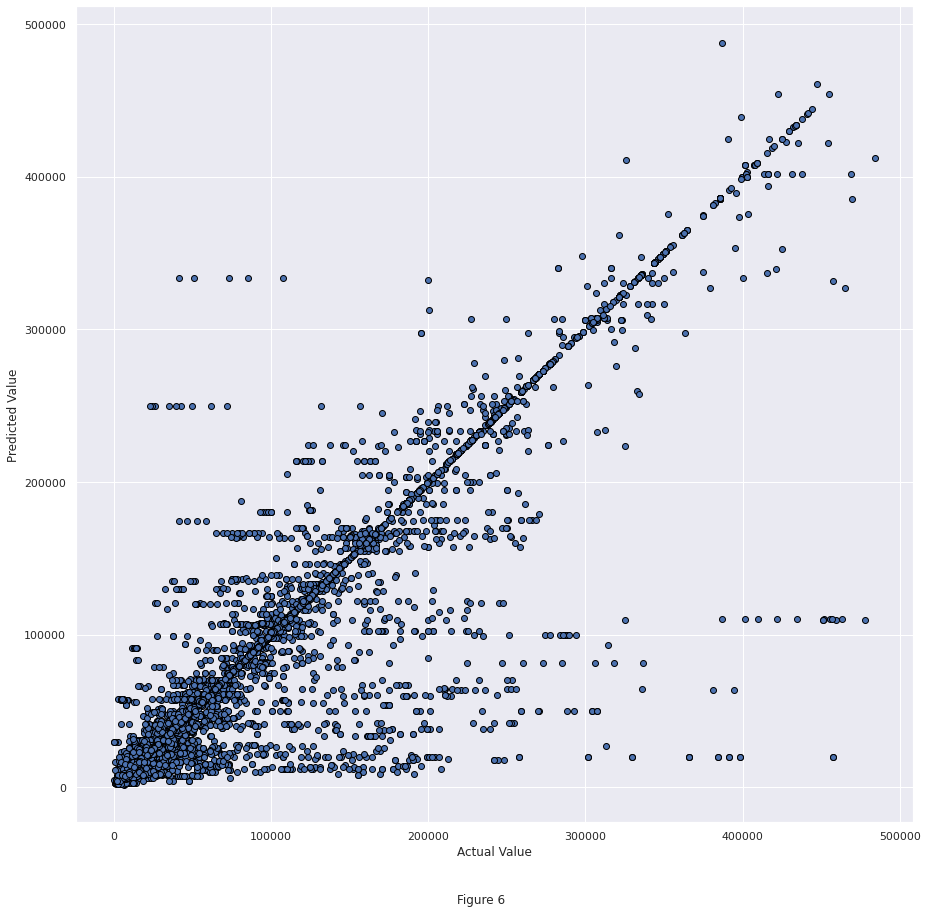

In [75]:
plt.figure(figsize=(15,15))
plt.scatter(test_labels["hg/ha_yield"], y_pred_gnb,edgecolors=(0, 0, 0))
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.figtext(0.5, 0.05, 'Figure 6',wrap=True, horizontalalignment='center', fontsize=12)

Figure 6 depicts the scatter plot of the actual vs expected values of the model generated by the Gaussian Naive Bayesian algorithm. The points spread throughout the figure reflect the variance between the actual and predicted value. 

**Gradient Boosting Regression model**

In [77]:
#model generation
yiled_GBR = GradientBoostingRegressor()
yiled_GBR.fit(train_data , train_labels)

#model prediction
y_pred_gbr = yiled_GBR.predict(test_data)

#model evaluation
score_gbr =r2_score(test_labels,y_pred_gbr)
models.append('Gradient Boosting Regression ')
scores.append(score_gbr)
score_gbr


0.7705653832982551

In [78]:
#convert the data into a data frame for displaying results
test_labels["hg/ha_yield"] = pd.DataFrame(test_labels)["hg/ha_yield"].tolist()

Text(0.5, 0.05, 'Figure 7')

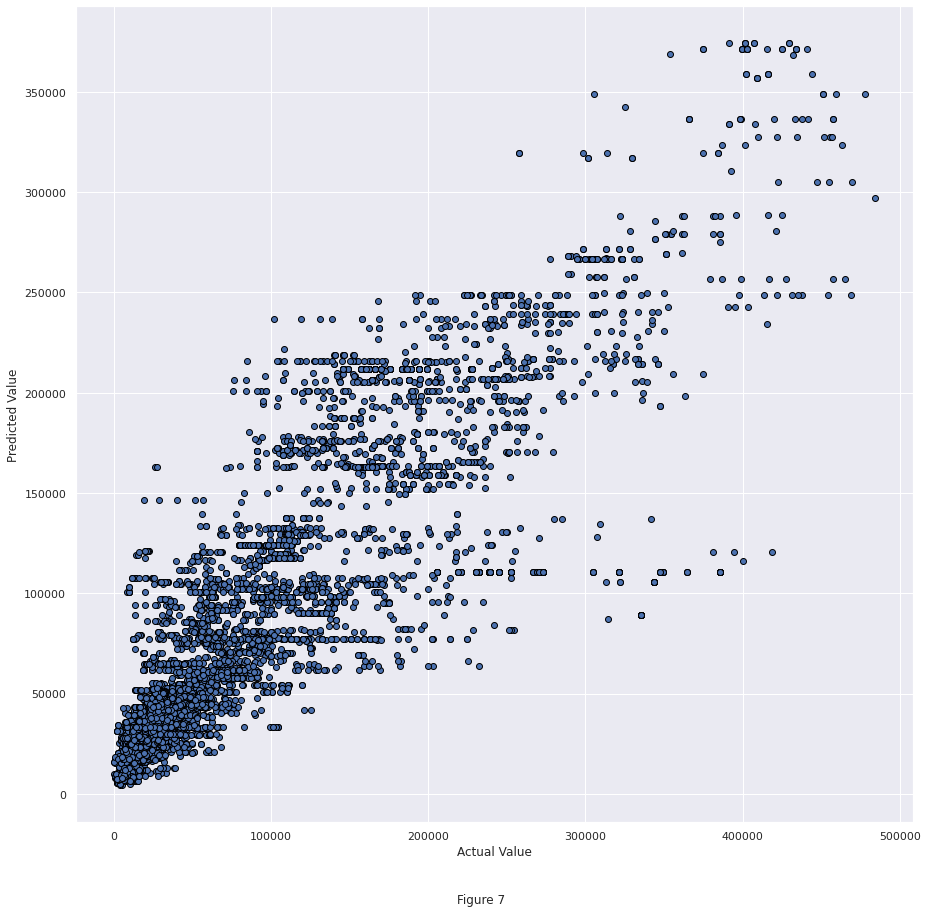

In [79]:
#box plot to display the crop yiled 
plt.subplots(figsize=(15,15))
plt.scatter(test_labels["hg/ha_yield"],y_pred_gbr,edgecolors=(0, 0, 0))
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.figtext(0.5, 0.05, 'Figure 7',wrap=True, horizontalalignment='center', fontsize=12)
            

We couldn't detect the regression diagonal line in figure 7, which suggests the model prediction is not very accurate.  

# Model comparison

We have generated and predicted values from three machine learning models using three different algorithms. We have also calculated the R-squared score for each model. Next we have to compare the models and find the best model for future predictions. 

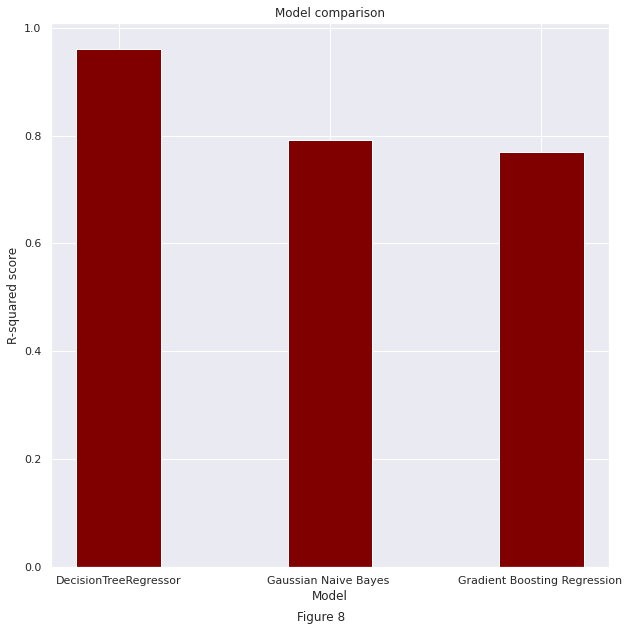

In [81]:
plt.subplots(figsize=(10,10))
plt.bar(models, scores, color ='maroon',
        width = 0.4)
 
plt.xlabel("Model")
plt.ylabel("R-squared score")
plt.title("Model comparison")
plt.figtext(0.5, 0.05, 'Figure 8',wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

The R-squared scores of each model are shown in Figure 8, and the decision tree regression algorithmic model appears to perform considerably more efficiently than the other two models. The same results are implied by fig.5-7, which visualizes the model performances.
Next we will explore the important features of the decision tree model. 

# Conclusion 

In [82]:
#fit the data to the bdecision tree classifier which performed best during our model generation stage
model=yiled_dt.fit(train_data,train_labels)
#retrieve the important features of the model
imp_features= {'importance': model.feature_importances_,'names':yield_dummies.columns[yield_dummies.columns!="hg/ha_yield"]}

Text(0.5, 0.05, 'Figure 9')

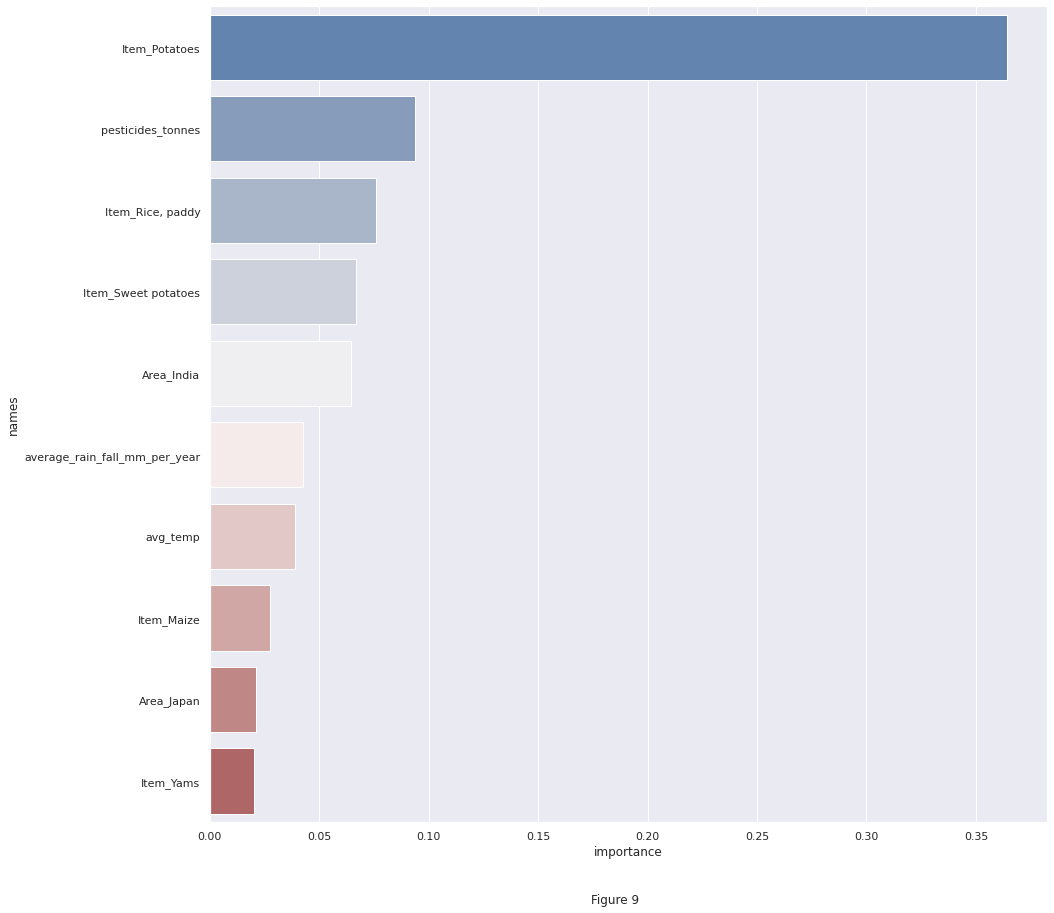

In [84]:
imp_features_data = pd.DataFrame.from_dict(imp_features)
imp_features_data.sort_values(ascending=False,by=["importance"],inplace=True)

#display top 10 important features of model
plt.subplots(figsize=(15,15))
imp_features_data=imp_features_data.nlargest(10, 'importance')
sns.barplot(x="importance",y="names",data=imp_features_data,palette="vlag",orient="h");
plt.figtext(0.5, 0.05, 'Figure 9',wrap=True, horizontalalignment='center', fontsize=12)

The model will have any number of features, and it will assign a score to each feature in both classification and regression issues. This score adds new information to the dataset and describes how the feature scores can be used to identify the model's most and least important features.The figure 9 explains the top ten most essential aspects of our decision tree regression model, as well as the feature scores. As a result, we may conclude that the item potatoes is the most essential characteristic of the model, with the highest number of yield value (fig.4). Then there are the pesticides. The rain fall rate and average temperature are the model's sixth and seventh features, respectively.

The model for predicting crop production values by farmers in this study takes into account the characteristics of the area, the item, the rain, the pesticide, and the temperature. For the purpose of creating the model, the publicly accessible datasets from the FAO (Food and Agriculture Organization) and the World Data Bank are combined into a single data set. The decision tree classifier model received the highest score in the evaluation of the models, outperforming the other two. The correctness of models is determined using the R-squred error value method. Gaussian naive bayes and gradient boosting regression models scored 79% and 77%, respectively, while the decision tree classifier model obtained a score of 96%. Additional research can take into account elements like soil quality, wind, humidity, etc.

# Acknowledgements
All dataset(publicly available dataset) here are taken form FAO (Food and Agriculture Organization) and World Data Bank.
http://www.fao.org/home/en/

https://data.worldbank.org/